<h1><center>Bayesian Data Analysis project report</center></h1>

<img src="http://icopartners.com/newblog/wp-content/uploads/2018/02/header.png">

<h1><center>Luxury Shirts Inc.</center></h1>


 <img src="https://drive.google.com/uc?export=download&id=1cqwKzgjgL7Rc-dVvoHCFoCZHY-ekO7wi"> 

* First product (the shirt pictured above) to launch on Kickstarter (https://www.kickstarter.com/about?ref=global-footer)
* Price point for the shirt is 200€
* The goal of the campaign is to gather 20 000€ to cover production and other expenses

#### How likely is it that the project will be successfull or should there be some changes to the pricing and/or goal?

## Introduction

The goal of this project and report is to analyze whether the presented business case seems plausible based on historical Kicstarter project data.

Kickstarter is a platform where users can submit different projects online and gather funding from other Kickstarter users. The main success metric for the projects is whether it managed to pledge more money that the goal set for the project. If the project does not meet or exceed the goal, all the pledged funding will be cancleled and the project labeled as unsuccessful.

In this particular analysis problem, we will analyze the needed amount of backers (people willing to fund the project) to have a high probability of success given the scale of the project and seeing whether this project fits in that predicted requirement.

This notebook will present the following:
* Description of the data and analysis problem
* Description of the used model and comparison to other tested models
* Discussion about used priors
* Technical implementation of the model and running it
* Convergence analysis and predictive checking
* Conclusion based on the results
* Discussion about potential improvements

## Description of data and analysis problem

The data used for this analysis is historical Kickstarter project data downloaded from Kaggle (https://www.kaggle.com/kemical/kickstarter-projects).

The main used data points per project are:
* Success (boolean)
* Goal of the project ($)
* Amount of backers (int)
* Category of the project

Other data were also available for the projects such as the amount of money pledged, but due to the nature of the analysis problem we only concentrate on variables that are known before the project has started.

The data set has over 370 000 data points, but we have cut it down based on some thresholds and also resampled it for more efficient computation. The success metric has also been converted to be binary instead of containing multiple values (all canceled ones removed for example).

If you want to run the model yourself, you should download the zip file from the foillowing link and extract the csv file as "projects.csv": https://www.kaggle.com/kemical/kickstarter-projects/downloads/kickstarter-projects.zip/3

In the following code we will tranform the data into useful form and display the first few rows of the data to get a grasp how it looks like. How the data is used in our model will be discussed in the next section.

In [1]:
#Import librararies that will be used throughout this notebook
import pystan
from pystan import StanModel
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from IPython.display import display, HTML
from psis import psisloo
from sklearn.model_selection import StratifiedKFold, ShuffleSplit, KFold
from sklearn.utils import resample

In [2]:
projects = pd.read_csv("projects.csv", header=None)
pm = np.array(projects) #All project data
pm = np.delete(pm, (0), axis=0) #Delete top row
pm = np.delete(pm, (0,1,2,4,5,7,8,11,12,13,14,15,16), axis=1) #Delete non needed columns


success_idx = pm[:,2] == "successful" #Tuple of all indexes that are successful
failed_idx = pm[:,2] == "failed" #Tuple of all indexes that failed

#Remove all rows where the end result is not successful or failed
remove_idx = np.where(np.logical_or(success_idx,failed_idx)==False)
pm = np.delete(pm, remove_idx, axis=0)

#Find new indexes for success and fail cases
success_idx = pm[:,2] == "successful"
failed_idx = pm[:,2] == "failed"

#Replace failed values with 0, success with 0 and convert whole matrix to numeric values
pm[success_idx,2] = 1
pm[failed_idx,2] = 0

#Remove all rows where the data points are below a threshold
remove_idx = np.where(pm[:,3].astype(int) < 10) #Remove all projects with backer count less than 10
pm = np.delete(pm, remove_idx, axis=0)

category_idx = np.where((pm[:,0] == "Fashion") | (pm[:,0] == 'Apparel'))
pm_cat = pm[category_idx]


pm = resample(pm,n_samples=5000,random_state=0) #Resample data used in fitting into model
pm_cat = resample(pm_cat,n_samples=5000,random_state=0)

print("Data points after formatting data and resampling in all projects: ",pm.shape[0])
print("Data points after formatting data and resampling in fashion category: ",pm_cat.shape[0])

pd.DataFrame(pm).to_csv("sanitized.csv",header=False, index=False)
sanitized = pd.read_csv("sanitized.csv", header=None, names=["Category","Goal ($)","Success (bool)","Backers (int)"])
display(HTML(sanitized.head(50).to_html(max_rows=50)))
print(pm.shape)

C:\Users\Matias\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (0,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Data points after formatting data and resampling in all projects:  5000
Data points after formatting data and resampling in fashion category:  5000


,Category,Goal ($),Success (bool),Backers (int)
0,Film & Video,90000.0,0,264
1,Music,2000.0,1,86
2,Music,1000.0,1,30
3,Technology,30000.0,0,57
4,Film & Video,5000.0,1,57
5,Music,3000.0,1,91
6,Film & Video,2000.0,1,26
7,Theater,3800.0,1,62
8,Art,50000.0,0,158
9,Music,7500.0,1,184


(5000, 4)


## Description of the model

Given the binary nature of the data, a binomial model is the most appropriate for this particular problem. The data points $y_i$ are binomially distributed and the model is of the form: <h3>$$y_i | θ_i ∼ Bin( n_i , θ_i ),$$</h3> 

where $θ_i$ is the probability of success for each project. The form and different variations of $θ_i$ tested during this project are discussed below. One example of models tested will be <h3>$$logit(θ_i) = a + bs + cg,$$</h3>

where $s$ (supporters) is the amount of backers of the project and $g$ (goal) is the goal of the project. To make sure that the probability $θ_i$ lies between 0 and 1, we use the logit transformation as shown above. The interesting insights we will draw from this equation is that we set a desired probability of success (80% in our case), and use the parameter values drawn from the posterior distrubution to evaluate the distribution of the desired variables (such as backer count).

In this report we will evaluate 3 different models in total and evaluate them with PSIS-LOO predictive checking:
* <h3>$logit(θ_i) = a + bs,$</h3>
* <h3>$logit(θ_i) = a + cg,$</h3>
* <h3>$logit(θ_i) = a + bs + cg$</h3>

where $s$ denotes the backer count, and $g$ denotes the goal of a project.

In addition to testing the three models, we will also test the models with data that belongs to the same category with our project (i.e. fashion).

## Discussion about priors

We will define some priors in the models for the parameters $b$ and $c$. These will be justified rather intuitively than based on domain experience. But in general we would expect that achieving a higher number of backers correlates positively with the success of the project. Inversely, a higher goal seems like a harder thing to actually achieve and therefore making it correlate negatively with the end result. We'll use the following priors for these parameters:
* <h3>$b$ ~ $normal(1,10)$</h3>
* <h3>$c$ ~ $normal(-0.5,5)$</h3>

## Stan implementation and running

We'll implement the stan models as strings and save them as files from the python code. This workflow has proved to be the most efficient throughout the project and it also enchances readability.

#### Model 1

In [3]:
stan_content_1 = """
data {
    int N; // amount of projects
    int n[N]; //projects 

    vector [N] s; // backers
    int y[N]; // success
}

parameters {
    real a;
    real b;
}

model {
    b ~ normal(1,10);
    y ~ binomial_logit(N, a + b*s);
}

generated quantities {
  vector[N] log_lik;
  for (i in 1:N) {
    log_lik[i] = binomial_logit_lpmf(y[i] | n[i], a + b*s[i]);
  }
}
"""
stan_file_1 = open("model_1.stan", "w")
stan_file_1.write(stan_content_1)
stan_file_1.close()

#### Model 2

In [4]:
stan_content_2 = """
data {
    int N; // amount of projects
    int n[N]; //projects 

    vector [N] g; // goal
    int y[N]; // success
}

parameters {
    real a;
    real c;
}

model {
    c ~ normal(-0.5,5);
    y ~ binomial_logit(N, a + c*g);
}

generated quantities {
  vector[N] log_lik;
  for (i in 1:N) {
    log_lik[i] = binomial_logit_lpmf(y[i] | n[i], a + c*g[i]);
  }
}
"""
stan_file_2 = open("model_2.stan", "w")
stan_file_2.write(stan_content_2)
stan_file_2.close()

#### Model 3

In [5]:
stan_content_3 = """
data {
    int N; // amount of projects
    int n[N]; //projects 

    vector [N] g; // goal
    vector [N] s; // backers
    int y[N]; // success
}

parameters {
    real a;
    real b;
    real c;
}

model {
    b ~ normal(1,10);
    c ~ normal(-0.5,5);
    y ~ binomial_logit(N, a + b*s + c*g);
}

generated quantities {
  vector[N] log_lik;
  for (i in 1:N) {
    log_lik[i] = binomial_logit_lpmf(y[i] | n[i], a + b*s[i] + c*g[i]);
  }
}
"""
stan_file_3 = open("model_3.stan", "w")
stan_file_3.write(stan_content_3)
stan_file_3.close()

Next, let's format the data so that we can fit it into the model

In [6]:
#All projects
g = np.asarray(pm[:,1].astype(float).astype(int)) # Goal
y = np.asarray(pm[:,2].astype(float).astype(int)) # Success
s = np.asarray(pm[:,3].astype(float).astype(int)) # Backers / supporters

#Fashion category
g_cat = np.asarray(pm_cat[:,1].astype(float).astype(int)) # Goal
y_cat = np.asarray(pm_cat[:,2].astype(float).astype(int)) # Success
s_cat = np.asarray(pm_cat[:,3].astype(float).astype(int)) # Backers / supporters

N = pm.shape[0] # Size of data
n = np.asarray(np.ones((N,1))[:,0]).astype(int) # Projects per group, always = 1
print(N)


5000


Next, let's fit the data into each model and print a summary

#### Model 1
* All data

In [7]:
data_1_all= {
    's':np.log(s_cat),
    'y':y,
    'N': N,
    'n': n
}

model_1_all = pystan.StanModel(file='model_1.stan')
fit_1_all = model_1_all.sampling(data=data_1_all)
samples_1_all = fit_1_all.extract(permuted=True)
print(fit_1_all)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d96b445fa8445a4aba9880eabb8d9503 NOW.
C:\Users\Matias\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Matias\AppData\Local\Temp\tmp48t51c_3\stanfit4anon_model_d96b445fa8445a4aba9880eabb8d9503_1954943822358515424.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Inference for Stan model: anon_model_d96b445fa8445a4aba9880eabb8d9503.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a              -8.87  2.0e-3   0.06  -8.98  -8.91  -8.87  -8.83  -8.76    820    1.0
b            -4.3e-3  4.8e-4   0.01  -0.03  -0.01-4.5e-3 5.4e-3   0.02    844    1.0
log_lik[1]   -1.4e-4  4.0e-8 2.4e-6-1.4e-4-1.4e-4-1.4e-4-1.4e-4-1.3e-4   3721    1.0
log_lik[2]     -8.88  2.9e-4   0.02  -8.92   -8.9  -8.88  -8.87  -8.85   3262    1.0
log_lik[3]     -8.88  2.7e-4   0.02  -8.92   -8.9  -8.88  -8.87  -8.85   3657    1.0
log_lik[4]   -1.4e-4  6.9e-8 2.7e-6-1.4e-4-1.4e-4-1.4e-4-1.4e-4-1.3e-4   1516    1.0
log_lik[5]      -8.9  1.1e-3   0.04  -8.97  -8.92   -8.9  -8.87  -8.82   1156    1.0
log_lik[6]     -8.88  6.3e-4   0.02  -8.92  -8.89  -8.88  -8.87  -8.84   1193    1.0
log_lik[7]     -8.88  4.8e-4   0.02  -8.92  -8

* Category data

In [8]:
data_1_cat= {
    's':np.log(s),
    'y':y_cat,
    'N': N,
    'n': n
}

model_1_cat = pystan.StanModel(file='model_1.stan')
fit_1_cat = model_1_cat.sampling(data=data_1_cat)
samples_1_cat = fit_1_cat.extract(permuted=True)
print(fit_1_cat)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d96b445fa8445a4aba9880eabb8d9503 NOW.
C:\Users\Matias\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Matias\AppData\Local\Temp\tmpoa124rex\stanfit4anon_model_d96b445fa8445a4aba9880eabb8d9503_6658241148725611673.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Inference for Stan model: anon_model_d96b445fa8445a4aba9880eabb8d9503.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a              -9.05  2.4e-3   0.06  -9.19   -9.1  -9.05  -9.01  -8.93    682   1.01
b             9.8e-3  5.5e-4   0.01  -0.02-1.4e-4 9.4e-3   0.02   0.04    713   1.01
log_lik[1]   -1.2e-4  8.4e-8 3.4e-6-1.3e-4-1.3e-4-1.2e-4-1.2e-4-1.2e-4   1633    1.0
log_lik[2]     -9.01  3.0e-4   0.02  -9.05  -9.02  -9.01   -9.0  -8.97   3933    1.0
log_lik[3]   -1.2e-4  7.5e-8 2.6e-6-1.3e-4-1.2e-4-1.2e-4-1.2e-4-1.2e-4   1235   1.01
log_lik[4]   -1.2e-4  3.9e-8 2.3e-6-1.3e-4-1.2e-4-1.2e-4-1.2e-4-1.2e-4   3305    1.0
log_lik[5]     -9.01  3.2e-4   0.02  -9.05  -9.03  -9.01   -9.0  -8.98   3300    1.0
log_lik[6]   -1.2e-4  3.7e-8 2.3e-6-1.3e-4-1.2e-4-1.2e-4-1.2e-4-1.2e-4   3912    1.0
log_lik[7]   -1.2e-4  8.4e-8 2.8e-6-1.3e-4-1.2

#### Model 2
* All data

In [9]:
data_2_all= {
    'g':np.log(g),
    'y':y,
    'N': N,
    'n': n
}

model_2_all = pystan.StanModel(file='model_2.stan')
fit_2_all = model_2_all.sampling(data=data_2_all)
samples_2_all = fit_2_all.extract(permuted=True)
print(fit_2_all)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3ba16203c244ddbcd53d411c8b651963 NOW.
C:\Users\Matias\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Matias\AppData\Local\Temp\tmpxzio44jn\stanfit4anon_model_3ba16203c244ddbcd53d411c8b651963_2832566383364763056.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Inference for Stan model: anon_model_3ba16203c244ddbcd53d411c8b651963.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a              -7.64  3.7e-3   0.09  -7.82  -7.71  -7.65  -7.58  -7.46    639    1.0
c              -0.15  4.4e-4   0.01  -0.17  -0.15  -0.15  -0.14  -0.13    638    1.0
log_lik[1]   -8.9e-5  1.2e-7 3.5e-6-9.6e-5-9.2e-5-8.9e-5-8.7e-5-8.2e-5    820    1.0
log_lik[2]     -8.76  4.3e-4   0.02   -8.8  -8.78  -8.76  -8.75  -8.73   1886    1.0
log_lik[3]     -8.66  6.9e-4   0.02  -8.71  -8.68  -8.66  -8.65  -8.62   1107    1.0
log_lik[4]   -1.0e-4  9.5e-8 3.0e-6-1.1e-4-1.1e-4-1.0e-4-1.0e-4-9.9e-5   1012    1.0
log_lik[5]      -8.9  3.1e-4   0.02  -8.93  -8.91   -8.9  -8.89  -8.86   3300    1.0
log_lik[6]     -8.82  3.4e-4   0.02  -8.86  -8.84  -8.82  -8.81  -8.79   2719    1.0
log_lik[7]     -8.76  4.3e-4   0.02   -8.8  -8

* Category data

In [10]:
data_2_cat= {
    'g':np.log(g_cat),
    'y':y_cat,
    'N': N,
    'n': n
}

model_2_cat = pystan.StanModel(file='model_2.stan')
fit_2_cat = model_2_cat.sampling(data=data_2_cat)
samples_2_cat = fit_2_cat.extract(permuted=True)
print(fit_2_cat)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3ba16203c244ddbcd53d411c8b651963 NOW.
C:\Users\Matias\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Matias\AppData\Local\Temp\tmpk744s__a\stanfit4anon_model_3ba16203c244ddbcd53d411c8b651963_7482241629341387011.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Inference for Stan model: anon_model_3ba16203c244ddbcd53d411c8b651963.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a              -7.66  4.2e-3    0.1  -7.85  -7.73  -7.66  -7.59  -7.47    567   1.01
c              -0.16  4.9e-4   0.01  -0.18  -0.17  -0.16  -0.15  -0.14    567   1.01
log_lik[1]   -9.2e-5  8.5e-8 2.7e-6-9.7e-5-9.3e-5-9.2e-5-9.0e-5-8.7e-5    975   1.01
log_lik[2]     -8.93  3.6e-4   0.02  -8.97  -8.94  -8.93  -8.92   -8.9   2703    1.0
log_lik[3]   -1.1e-4  4.6e-8 2.2e-6-1.1e-4-1.1e-4-1.1e-4-1.1e-4-1.0e-4   2347    1.0
log_lik[4]   -1.1e-4  4.6e-8 2.2e-6-1.1e-4-1.1e-4-1.1e-4-1.1e-4-1.0e-4   2347    1.0
log_lik[5]     -8.98  2.9e-4   0.02  -9.01  -8.99  -8.98  -8.97  -8.94   3795    1.0
log_lik[6]   -1.0e-4  6.1e-8 2.4e-6-1.1e-4-1.0e-4-1.0e-4-1.0e-4-9.8e-5   1500   1.01
log_lik[7]   -1.1e-4  3.8e-8 2.2e-6-1.2e-4-1.2

#### Model 3
* All data

In [11]:
data_3_all= {
    'g':np.log(g),
    's':np.log(s),
    'y':y,
    'N': N,
    'n': n
}

model_3_all = pystan.StanModel(file='model_3.stan')
fit_3_all = model_3_all.sampling(data=data_3_all)
samples_3_all = fit_3_all.extract(permuted=True)
print(fit_3_all)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e2a643d7ea11fa77ed054be509cca9e5 NOW.
C:\Users\Matias\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Matias\AppData\Local\Temp\tmpc03qjxy9\stanfit4anon_model_e2a643d7ea11fa77ed054be509cca9e5_4700567109920238721.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Inference for Stan model: anon_model_e2a643d7ea11fa77ed054be509cca9e5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a              -8.08  2.5e-3   0.09  -8.26  -8.15  -8.08  -8.02   -7.9   1416    1.0
b               0.33  3.4e-4   0.01    0.3   0.32   0.33   0.34   0.36   1680    1.0
c              -0.26  3.3e-4   0.01  -0.29  -0.27  -0.26  -0.26  -0.24   1335    1.0
log_lik[1]   -9.6e-5  8.9e-8 3.6e-6-1.0e-4-9.8e-5-9.6e-5-9.3e-5-8.9e-5   1627    1.0
log_lik[2]     -8.62  3.5e-4   0.02  -8.65  -8.63  -8.62  -8.61  -8.58   2911    1.0
log_lik[3]     -8.78  5.1e-4   0.02  -8.83   -8.8  -8.78  -8.77  -8.74   2135    1.0
log_lik[4]   -7.7e-5  5.9e-8 2.5e-6-8.2e-5-7.9e-5-7.7e-5-7.6e-5-7.3e-5   1777    1.0
log_lik[5]      -9.0  3.1e-4   0.02  -9.03  -9.01   -9.0  -8.98  -8.96   3599    1.0
log_lik[6]     -8.71  2.8e-4   0.02  -8.74  -8

* Category data

In [12]:
data_3_cat= {
    'g':np.log(g_cat),
    's':np.log(s_cat),
    'y':y_cat,
    'N': N,
    'n': n
}

model_3_cat = pystan.StanModel(file='model_3.stan')
fit_3_cat = model_3_cat.sampling(data=data_3_cat)
samples_3_cat = fit_3_cat.extract(permuted=True)
print(fit_3_cat)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e2a643d7ea11fa77ed054be509cca9e5 NOW.
C:\Users\Matias\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Matias\AppData\Local\Temp\tmp_6zw4s3n\stanfit4anon_model_e2a643d7ea11fa77ed054be509cca9e5_5434502376729847171.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Inference for Stan model: anon_model_e2a643d7ea11fa77ed054be509cca9e5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a              -8.34  2.6e-3    0.1  -8.54   -8.4  -8.34  -8.27  -8.14   1455    1.0
b               0.43  4.5e-4   0.01    0.4   0.41   0.43   0.44   0.45   1094    1.0
c              -0.29  3.6e-4   0.01  -0.31   -0.3  -0.29  -0.28  -0.26   1301    1.0
log_lik[1]   -7.8e-5  6.0e-8 2.5e-6-8.4e-5-8.0e-5-7.8e-5-7.7e-5-7.4e-5   1714    1.0
log_lik[2]     -9.03  3.7e-4   0.02  -9.07  -9.04  -9.03  -9.01  -8.99   2850    1.0
log_lik[3]   -8.9e-5  5.0e-8 2.2e-6-9.4e-5-9.1e-5-8.9e-5-8.8e-5-8.5e-5   1937    1.0
log_lik[4]   -6.8e-5  5.5e-8 2.1e-6-7.2e-5-6.9e-5-6.8e-5-6.6e-5-6.4e-5   1437    1.0
log_lik[5]     -7.98  9.0e-4   0.04  -8.05  -8.01  -7.98  -7.96  -7.91   1542    1.0
log_lik[6]   -5.3e-5  5.5e-8 2.0e-6-5.7e-5-5.4

## Convergence analysis
...

## Model comparison
Let's calculate the PSIS-LOO and k values to compare the models and the reliability. (The PSIS-LOO function provided in the appendix and it should be run if this notebook is run locally).

The PSIS-LOO value for model  1 All  is  -30778.30955322821

 k-values plotted


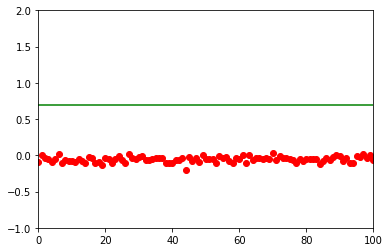

The PSIS-LOO value for model  1 Cat  is  -27430.05421716773

 k-values plotted


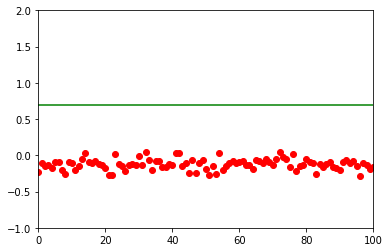

The PSIS-LOO value for model  2 All  is  -30691.414058888855

 k-values plotted


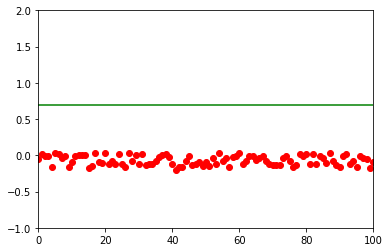

The PSIS-LOO value for model  2 Cat  is  -27345.947565184135

 k-values plotted


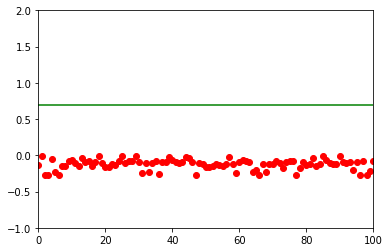

The PSIS-LOO value for model  3 All  is  -30422.463252502017

 k-values plotted


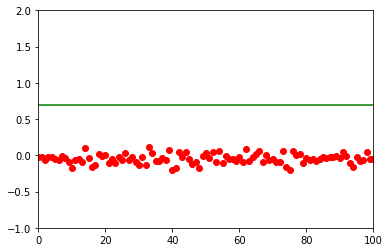

The PSIS-LOO value for model  3 Cat  is  -26957.293984492124

 k-values plotted


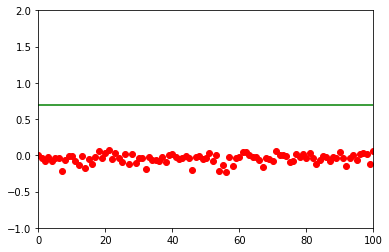

In [13]:

samples = [samples_1_all,samples_1_cat,samples_2_all,samples_2_cat,samples_3_all,samples_3_cat]
sample_names = ["1 All","1 Cat","2 All","2 Cat","3 All","3 Cat",]

i = 0
for sample in samples:
    
    loo, loos, ks = psisloo(sample['log_lik'])
    print("The PSIS-LOO value for model ",sample_names[i]," is ",loo)
    print("\n k-values plotted")
    plt.plot(ks,'ro')
    plt.axis([0, 100, -1, 2])
    plt.axhline(0.7, color='g')
    plt.show();
    i += 1

## Results/Conclusion

Based on the above, the best model seems to the the third model as the PSIS-LOO value is the lowest and the k values are all under the 0.7 threshold.

Next, we'll use the model to calculate whether our business case makes sense. In our project, we'll assume that each backer will pledge the exact cost of our shirt. Given our price for the shirt and the goal, we'd need 1000 backers. Let's see how the distribution of amount of backers needed to have 80% chance of success given our goal amount looks like:



(array([  3.,   2.,   6.,   9.,  14.,  18.,  22.,  33.,  47.,  58.,  63.,
         84., 105., 125., 138., 167., 155., 199., 204., 210., 217., 217.,
        198., 191., 163., 177., 157., 131., 148., 123., 109.,  97.,  84.,
         63.,  47.,  35.,  34.,  38.,  25.,  23.,  22.,  13.,   5.,   8.,
          6.,   1.,   2.,   3.,   0.,   1.]),
 array([28.2795331 , 28.3991024 , 28.51867169, 28.63824098, 28.75781028,
        28.87737957, 28.99694887, 29.11651816, 29.23608745, 29.35565675,
        29.47522604, 29.59479533, 29.71436463, 29.83393392, 29.95350321,
        30.07307251, 30.1926418 , 30.31221109, 30.43178039, 30.55134968,
        30.67091897, 30.79048827, 30.91005756, 31.02962685, 31.14919615,
        31.26876544, 31.38833473, 31.50790403, 31.62747332, 31.74704261,
        31.86661191, 31.9861812 , 32.1057505 , 32.22531979, 32.34488908,
        32.46445838, 32.58402767, 32.70359696, 32.82316626, 32.94273555,
        33.06230484, 33.18187414, 33.30144343, 33.42101272, 33.54058202,
 

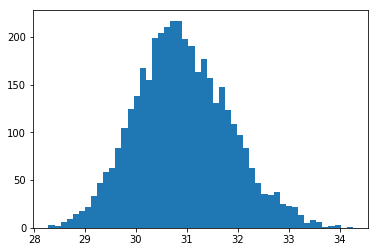

In [22]:
a_samples = samples[-1]['a']
b_samples = samples[-1]['b']
c_samples = samples[-1]['c']
goal = np.log(8000)
#goal = 20000

backers = (2.19-a_samples-c_samples*goal) / b_samples # Distribution when the probability of success is 90%
plt.hist(backers,50)


## Problems and improvement ideas
...